In [2]:
# @title <<
# @markdown # **Spotify Music Recommender System**
# @markdown This notebook builds a comprehensive music recommender system using the Spotify API and various machine learning techniques.
# @markdown ---
# @markdown ## **1. Setup and Authentication**
# @markdown First, we install the necessary libraries and set up our connection to the Spotify API using the `spotipy` library.
# @markdown
# @markdown **Important:** To use the Spotify API, you need to get your own `client_id` and `client_secret` from the [Spotify Developer Dashboard](https://developer.spotify.com/dashboard/).
# @markdown Once you have them, paste them into the fields below.


In [3]:
!pip install spotipy pandas numpy scikit-learn matplotlib seaborn plotly -q

import os
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import warnings

warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 11.2 MB/s eta 0:00:00


In [4]:
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from getpass import getpass

# Secure credential input
client_id = getpass("🔐 Enter your Spotify Client ID: ")
client_secret = getpass("🔐 Enter your Spotify Client Secret: ")

if not client_id or not client_secret:
    print("🚨 Spotify credentials missing.")
else:
    os.environ['SPOTIPY_CLIENT_ID'] = client_id
    os.environ['SPOTIPY_CLIENT_SECRET'] = client_secret

    try:
        # Authenticate with Spotify
        client_credentials_manager = SpotifyClientCredentials()
        sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
        print("✅ Successfully authenticated with Spotify!")
    except Exception as e:
        print(f"🔥 Authentication failed: {e}")


🔐 Enter your Spotify Client ID: ··········
🔐 Enter your Spotify Client Secret: ··········
✅ Successfully authenticated with Spotify!


In [5]:
# @markdown ---
# @markdown ## **2. Data Collection**
# @markdown We have two options for data:
# @markdown 1.  **Fetch from Spotify API**: Use a playlist ID to get tracks directly from Spotify.
# @markdown 2.  **Use a Kaggle Dataset**: Load a pre-existing dataset. This is faster and doesn't require API calls for the initial data.
# @markdown
# @markdown We will use a popular Kaggle dataset for this demonstration. You can download it from [here](https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks).
# @markdown Please upload `tracks.csv` to your Colab environment.

In [6]:
import kagglehub
import shutil
import os

# Download the dataset to cache (default kagglehub behavior)
cached_path = kagglehub.dataset_download("yamaerenay/spotify-dataset-19212020-600k-tracks")

# Define the new desired path
target_path = "./content/"
os.makedirs(target_path, exist_ok=True)

# Move dataset files to ./content/
for file_name in os.listdir(cached_path):
    full_file_path = os.path.join(cached_path, file_name)
    if os.path.isfile(full_file_path):
        shutil.copy(full_file_path, os.path.join(target_path, file_name))

print("Dataset files copied to:", target_path)


100%|██████████| 193M/193M [00:05<00:00, 38.0MB/s]

Extracting files...


Dataset files copied to: ./content/


In [7]:
# --- Load Data ---
try:
    df_tracks = pd.read_csv('/content/content/tracks.csv')
    print("✅ Kaggle dataset `tracks.csv` loaded successfully.")
    print(f"Shape of the dataset: {df_tracks.shape}")
except FileNotFoundError:
    print("🚨 `tracks.csv` not found. Please upload the dataset to your Colab session.")
    df_tracks = pd.DataFrame() # Create empty dataframe to avoid errors

✅ Kaggle dataset `tracks.csv` loaded successfully.
Shape of the dataset: (586672, 20)



--- Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 1

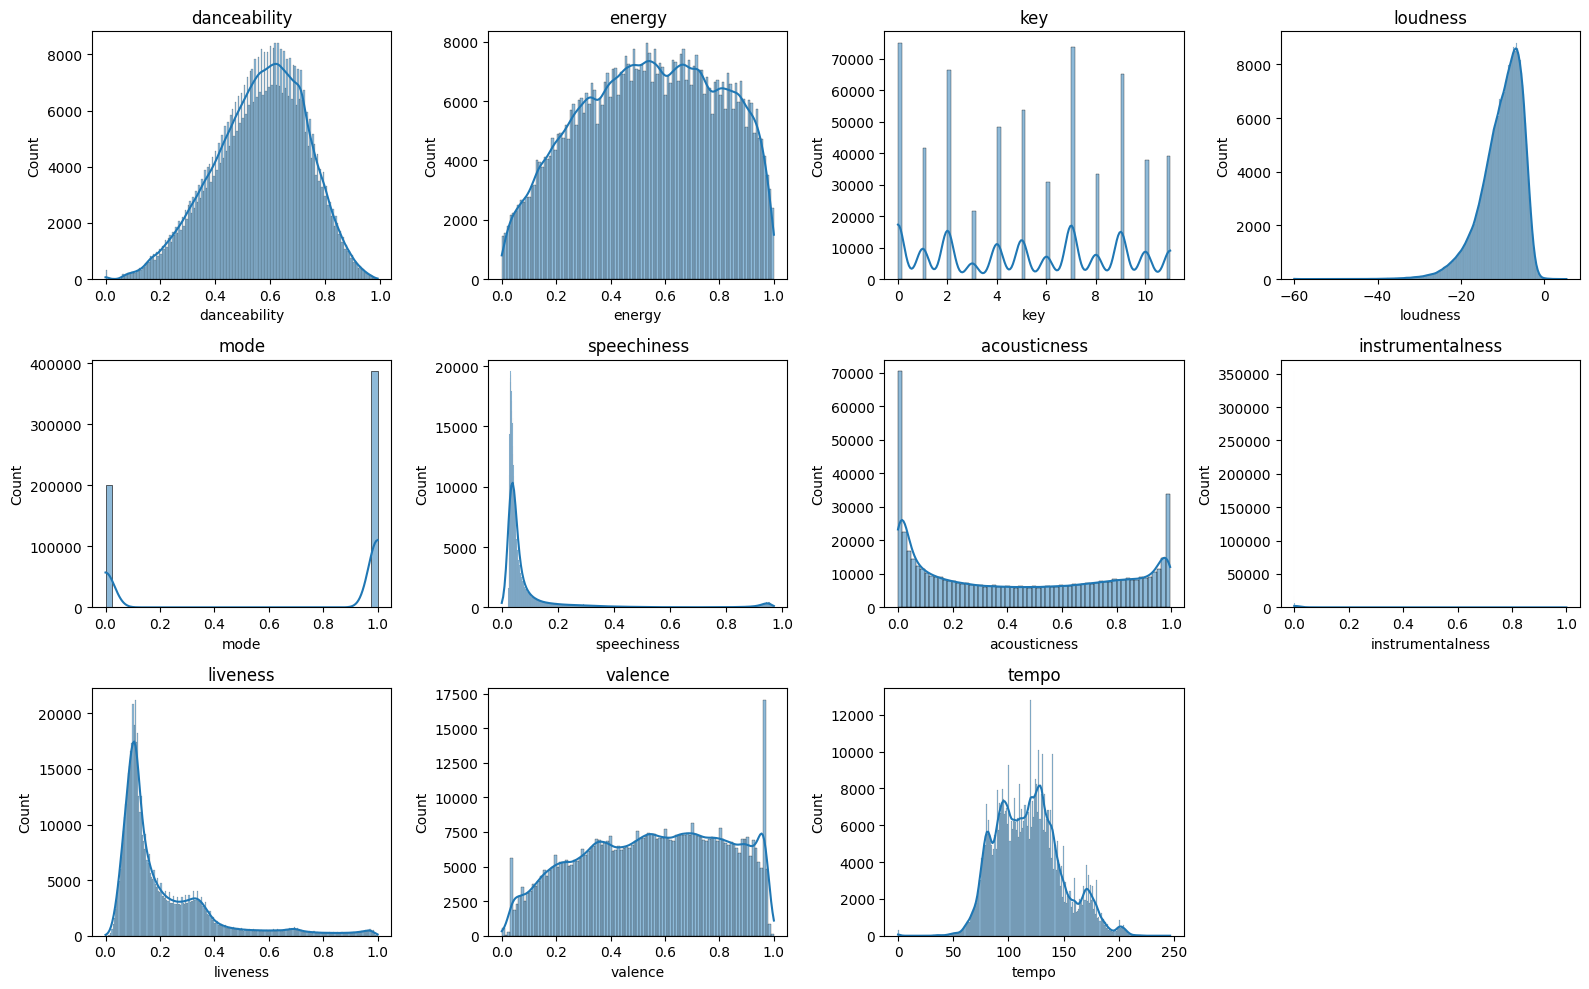


--- Visualizing Feature Correlation ---


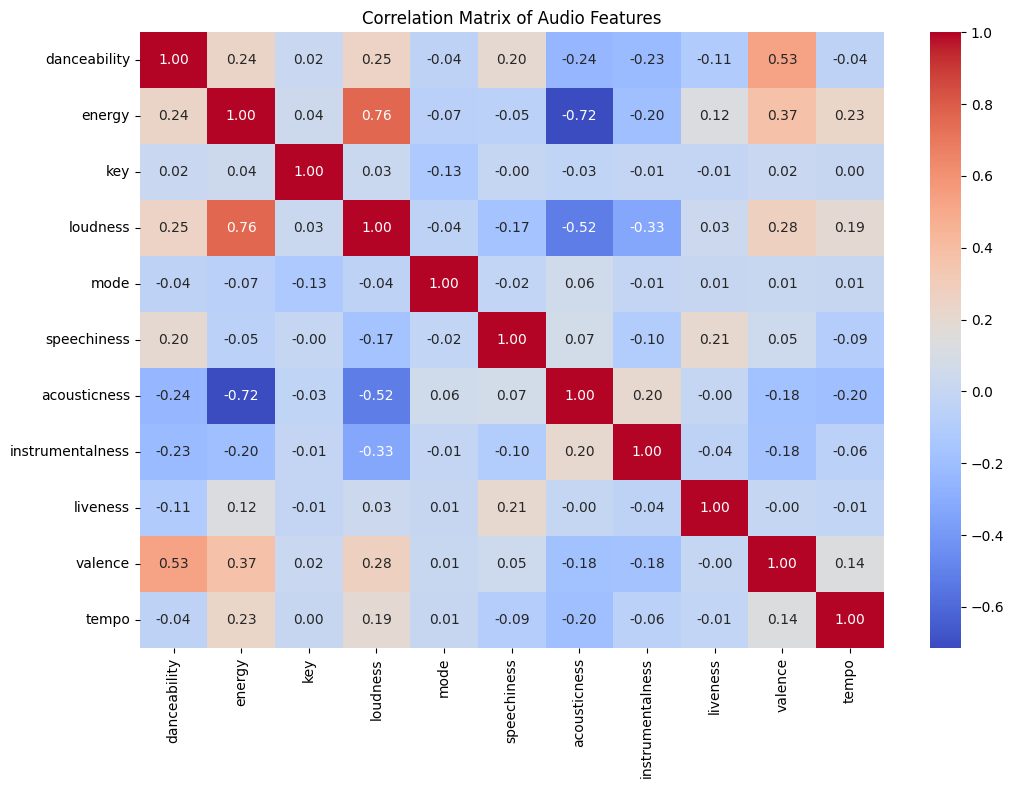

In [8]:
# @markdown ---
# @markdown ## **3. Exploratory Data Analysis (EDA) & Preprocessing**
# @markdown Let's explore the data and prepare it for our models.

if not df_tracks.empty:
    # Display basic info and a sample of the data
    print("\n--- Data Overview ---")
    print(df_tracks.info())
    print("\n--- Data Sample ---")
    print(df_tracks.head())

    # Select audio features
    audio_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                      'instrumentalness', 'liveness', 'valence', 'tempo']
    df_features = df_tracks[audio_features]

    # --- Preprocessing: Scale the features ---
    scaler = StandardScaler()
    df_features_scaled = scaler.fit_transform(df_features)
    df_features_scaled = pd.DataFrame(df_features_scaled, columns=audio_features)

    print("\n--- Scaled Features Sample ---")
    print(df_features_scaled.head())

    # --- EDA: Visualize Feature Distributions ---
    print("\n--- Visualizing Feature Distributions ---")
    plt.figure(figsize=(16, 10))
    for i, feature in enumerate(audio_features):
        plt.subplot(3, 4, i + 1)
        sns.histplot(df_tracks[feature], kde=True)
        plt.title(feature)
    plt.tight_layout()
    plt.show()

    # --- EDA: Correlation Matrix ---
    print("\n--- Visualizing Feature Correlation ---")
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_features.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Audio Features')
    plt.show()


In [9]:
# @markdown ---
# @markdown ## **4. Recommender System Implementations**
# @markdown Now we'll build our different recommender systems.

# Utility function to get track details from the dataframe
def get_track_details(track_name, df=df_tracks):
    """Fetches the first matching track's details from the dataframe."""
    track_query = df.loc[df['name'].str.lower() == track_name.lower()]
    if not track_query.empty:
        return track_query.iloc[0]
    return None # Return None if not found

# Utility function to display recommendations
def display_recommendations(recommendations_df):
    """Prints recommendations in a readable format."""
    print("\n--- Top Recommendations ---")
    for idx, row in recommendations_df.iterrows():
        # Using .get() for safer access to artist list
        artists = row.get('artists', 'Unknown Artist')
        print(f"  - {row['name']} by {artists}")

# --- 4.1. Content-Based Filtering Recommender (MEMORY OPTIMIZED) ---
def content_based_recommender(track_name, n_recommendations=10, display=True):
    """Recommends songs based on cosine similarity of audio features.
    This version is memory-efficient and avoids creating a full similarity matrix."""
    if df_tracks.empty:
        print("Data not loaded. Cannot provide recommendations.")
        return pd.DataFrame()

    # Find the track
    track_details = get_track_details(track_name)
    if track_details is None:
        print(f"Track '{track_name}' not found in the dataset.")
        return pd.DataFrame()

    track_index = track_details.name # Get the index of the track
    track_features = df_features_scaled.loc[track_index].values.reshape(1, -1)

    # Calculate cosine similarity between the input track and all other tracks
    sim_scores = cosine_similarity(track_features, df_features_scaled)
    sim_scores = list(enumerate(sim_scores[0]))

    # Sort tracks by similarity
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get top N similar tracks (excluding the input track itself)
    sim_scores = sim_scores[1:n_recommendations+1]
    track_indices = [i[0] for i in sim_scores]
    recommendations = df_tracks.iloc[track_indices]

    if display:
        display_recommendations(recommendations[['name', 'artists']])

    return recommendations


# --- 4.2. Clustering-Based Recommender (K-Means) ---
# @markdown We'll first determine the optimal number of clusters using the Elbow Method.
# @markdown **Note:** This can be slow on a large dataset. We'll use a sample.
df_sample = df_features_scaled.sample(n=15000, random_state=42)
df_tracks_sample = df_tracks.loc[df_sample.index]

# Elbow Method
def find_optimal_kmeans_clusters(data, max_k=15):
    print("\nFinding optimal K for K-Means...")
    iters = range(2, max_k)
    sse = []
    for k in iters:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
        print(f"Completed K={k}")

    plt.figure(figsize=(10, 5))
    plt.plot(iters, sse, marker='o')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.title('Elbow Method for Optimal K')
    plt.grid(True)
    plt.show()

# Run the elbow method (optional, can be time-consuming)
# find_optimal_kmeans_clusters(df_sample)
# @markdown Based on the elbow plot, a value around 5-8 seems reasonable. Let's pick K=7.

# Perform K-Means Clustering
K = 7
kmeans = KMeans(n_clusters=K, random_state=42, n_init='auto')
df_tracks_sample['cluster_kmeans'] = kmeans.fit_predict(df_sample)

def kmeans_recommender(track_name, n_recommendations=10):
    """Recommends songs from the same K-Means cluster."""
    if df_tracks_sample.empty:
        print("Data not loaded/sampled. Cannot provide recommendations.")
        return
    try:
        # Get the cluster of the input track
        track_cluster = df_tracks_sample[df_tracks_sample['name'].str.lower() == track_name.lower()]['cluster_kmeans'].values[0]
    except IndexError:
        print(f"Track '{track_name}' not found in the sampled dataset for clustering.")
        return

    # Get other tracks from the same cluster
    recommendations = df_tracks_sample[df_tracks_sample['cluster_kmeans'] == track_cluster]
    recommendations = recommendations[recommendations['name'].str.lower() != track_name.lower()]

    recommendations = recommendations.sample(n=min(n_recommendations, len(recommendations)))[['name', 'artists']]
    display_recommendations(recommendations)
    return recommendations

# --- 4.3. Dimensionality Reduction-Based Recommender (PCA) ---
pca = PCA(n_components=2)
# Fit on the sample for consistency with clustering
df_pca = pca.fit_transform(df_features_scaled)
df_pca = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'], index=df_features_scaled.index)

def pca_recommender(track_name, n_recommendations=10):
    """Recommends songs based on nearest neighbors in PCA space."""
    if df_tracks.empty:
        print("Data not loaded. Cannot provide recommendations.")
        return
    track_details = get_track_details(track_name)
    if track_details is None:
        print(f"Track '{track_name}' not found in the dataset.")
        return

    track_index = track_details.name
    track_pca = df_pca.loc[track_index].values.reshape(1, -1)
    distances = np.linalg.norm(df_pca.values - track_pca, axis=1)

    # Get nearest neighbors
    nearest_indices = np.argsort(distances)[1:n_recommendations+1]
    recommendations = df_tracks.iloc[nearest_indices][['name', 'artists']]
    display_recommendations(recommendations)
    return df_tracks.iloc[nearest_indices]


# --- 4.4. Hybrid Recommender ---
# @markdown This hybrid model combines content-based similarity with popularity.
def hybrid_recommender(track_name, n_recommendations=10):
    """Recommends songs using content similarity and re-ranks by popularity."""
    if df_tracks.empty:
        print("Data not loaded. Cannot provide recommendations.")
        return

    # Get a larger pool of content-based recommendations without displaying them
    initial_recs = content_based_recommender(track_name, n_recommendations=50, display=False)
    if initial_recs.empty:
        return

    # Re-rank based on popularity
    sorted_recs = initial_recs.sort_values(by='popularity', ascending=False)
    final_recs = sorted_recs.head(n_recommendations)[['name', 'artists', 'popularity']]

    print("\n--- Top Hybrid Recommendations (Content + Popularity) ---")
    for index, row in final_recs.iterrows():
        print(f"  - {row['name']} by {row['artists']} (Popularity: {row['popularity']})")
    return final_recs


In [10]:

# @markdown ---
# @markdown ## **5. Visualization & Evaluation**

# --- 5.1. Visualize Clusters (t-SNE) ---
def visualize_clusters_tsne():
    print("\nGenerating t-SNE plot for K-Means clusters... (this may take a moment)")
    tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=300)
    df_tsne = tsne.fit_transform(df_sample)

    df_plot = pd.DataFrame(df_tsne, columns=['TSNE1', 'TSNE2'])
    df_plot['cluster'] = df_tracks_sample['cluster_kmeans'].values

    plt.figure(figsize=(14, 10))
    sns.scatterplot(data=df_plot, x='TSNE1', y='TSNE2', hue='cluster', palette='viridis', alpha=0.7)
    plt.title('t-SNE Visualization of K-Means Song Clusters')
    plt.legend(title='Cluster')
    plt.show()

# --- 5.2. Radar Plot for Feature Comparison ---
def plot_radar_chart(track_name, recommended_track_name):
    """Creates a radar chart comparing two tracks' audio features."""
    track1 = get_track_details(track_name)
    track2 = get_track_details(recommended_track_name)

    if track1 is None or track2 is None:
        print(f"Could not find one of the tracks for radar plot: '{track_name}' or '{recommended_track_name}'")
        return

    features_to_plot = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']
    track1_features = df_features_scaled.loc[track1.name, features_to_plot]
    track2_features = df_features_scaled.loc[track2.name, features_to_plot]

    fig = go.Figure()
    fig.add_trace(go.Scatterpolar(r=track1_features, theta=features_to_plot, fill='toself', name=f"{track1['name']} (Original)"))
    fig.add_trace(go.Scatterpolar(r=track2_features, theta=features_to_plot, fill='toself', name=f"{track2['name']} (Recommended)"))
    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[-2.5, 2.5])),
        showlegend=True,
        title=f"Audio Feature Comparison: '{track1['name']}' vs '{track2['name']}'"
    )
    fig.show()


# --- 5.3. Clustering Evaluation Metrics ---
def evaluate_clustering():
    """Calculates and prints clustering evaluation metrics."""
    if 'cluster_kmeans' not in df_tracks_sample.columns:
        print("K-Means clustering has not been run yet.")
        return

    silhouette = silhouette_score(df_sample, df_tracks_sample['cluster_kmeans'])
    davies_bouldin = davies_bouldin_score(df_sample, df_tracks_sample['cluster_kmeans'])

    print("\n--- K-Means Clustering Evaluation ---")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
    print("(Silhouette Score: Higher is better. Davies-Bouldin: Lower is better.)")





🚀 Getting recommendations for: 'Bohemian Rhapsody - Remastered 2011'

--- 1. Content-Based Recommender ---

--- Top Recommendations ---
  - Bohemian Rhapsody - Remastered 2011 by ['Queen']
  - 背著良心的說話 by ['Danny Chan', 'Bryan Choy Hin Lok', 'David Ling Jr. at Bali Studio']
  - Teringin by ['Shima']
  - De Waarheid by ['Marco Borsato']
  - Hard To Believe by ['Eraserheads']
  - Pílatus og Kristur by ['Daníel Ágúst Haraldsson']
  - Father of Creation - Live by ['Hillsong Worship', "Integrity's Hosanna! Music", 'Darlene Zschech']
  - I'm Not There by ['Bob Dylan']
  - Quédate by ['Los João']
  - 勉強幸福 by ['Yoga Lin']


--- 2. K-Means Clustering Recommender ---
Track 'Bohemian Rhapsody - Remastered 2011' not found in the sampled dataset for clustering.


--- 3. PCA-Based Recommender ---

--- Top Recommendations ---
  - Bohemian Rhapsody - Remastered 2011 by ['Queen']
  - Muñeca De Ojos De Miel by ['Los Mier']
  - Bis ans Ende der Welt - Live from Spotify Berlin by ['JORIS']
  - 走马 by ['陳粒

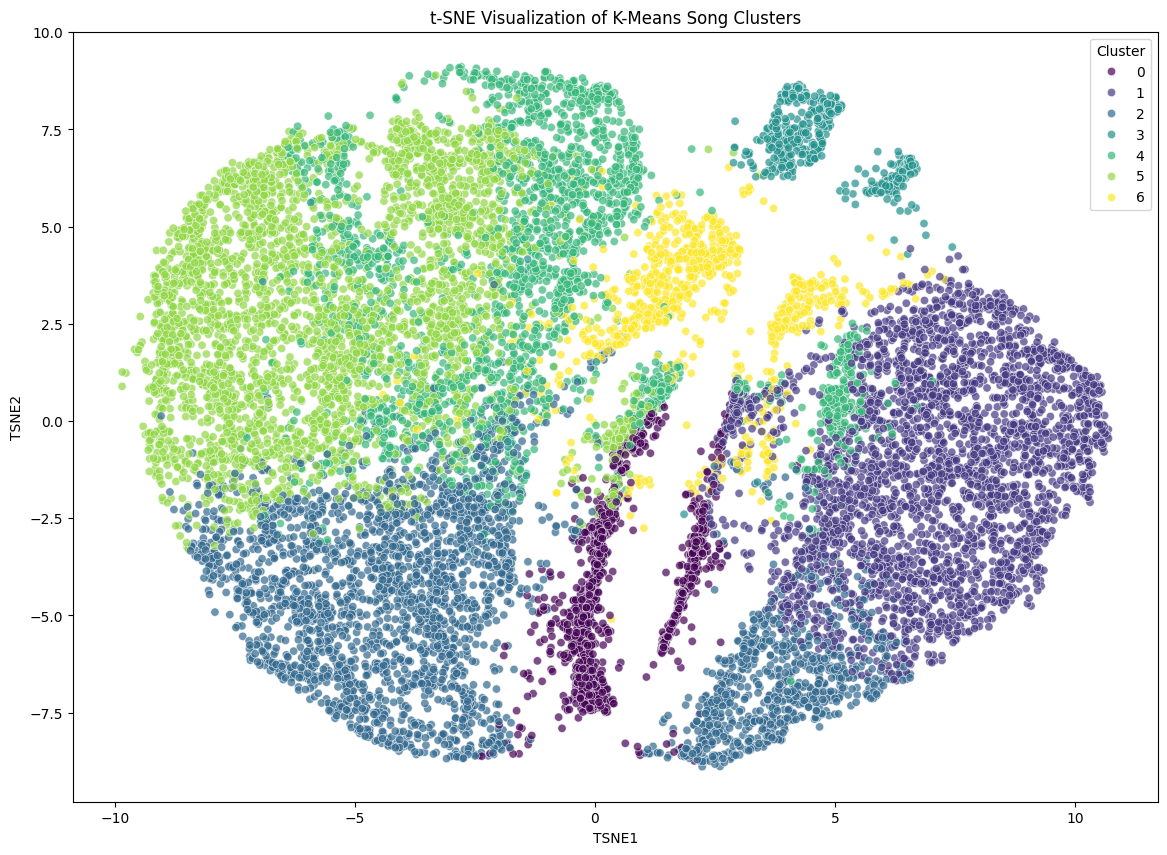


--- K-Means Clustering Evaluation ---
Silhouette Score: 0.1530
Davies-Bouldin Index: 1.7403
(Silhouette Score: Higher is better. Davies-Bouldin: Lower is better.)

Generating Radar Chart for 'Bohemian Rhapsody - Remastered 2011' and its top recommendation 'Bohemian Rhapsody - Remastered 2011'...


In [11]:

# @markdown ---
# @markdown ## **6. Putting It All Together: Get Recommendations**
# @markdown Now, you can test the recommenders with a song title.
input_track_name = "Bohemian Rhapsody - Remastered 2011" # @param {type:"string"}

if not df_tracks.empty:
    print(f"\n\n{'='*50}")
    print(f"🚀 Getting recommendations for: '{input_track_name}'")
    print(f"{'='*50}")

    print("\n--- 1. Content-Based Recommender ---")
    recs_content = content_based_recommender(input_track_name)

    print("\n\n--- 2. K-Means Clustering Recommender ---")
    kmeans_recommender(input_track_name)

    print("\n\n--- 3. PCA-Based Recommender ---")
    recs_pca = pca_recommender(input_track_name)

    print("\n\n--- 4. Hybrid Recommender (Content + Popularity) ---")
    recs_hybrid = hybrid_recommender(input_track_name)

    print(f"\n\n{'='*50}")
    print("📊 Running Visualizations & Evaluations")
    print(f"{'='*50}")

    visualize_clusters_tsne()
    evaluate_clustering()

    if recs_content is not None and not recs_content.empty:
        recommended_song = recs_content.iloc[0]['name']
        print(f"\nGenerating Radar Chart for '{input_track_name}' and its top recommendation '{recommended_song}'...")
        plot_radar_chart(input_track_name, recommended_song)
    else:
        print("\nCould not generate radar chart as no content-based recommendations were found.")

else:
    print("\n🚨 Cannot run recommendations because the dataset was not loaded.")